# Breast Cancer Classification Neural Network
This notebook will attempt to correctly diagnose wether a tumour is benign or malignant. The dataset was obtained by the University of Wisconsin Hospitals, Madison from Dr. William H. Wolberg.

## Data Exploration
First things first, we need to import the required packages:

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import StratifiedKFold

print(tf.__version__)
print('Setup Complete !')

2.0.0
Setup Complete !


After loading the pandas package and we'll use the *read_csv* method to load the dataset and use the *.shape* attribute to explore the dimensions of it.

In [32]:
wbcr_data = pd.read_csv('../datasets/breast-cancer-wisconsin.data')
print(wbcr_data.shape)

(698, 11)


We can see that our data is 2 Dimensional (698 rows and 11 columns). Now let's take a look at the values: 

In [33]:
print(wbcr_data.head())

   1000025  5   1  1.1  1.2  2 1.3  3  1.4  1.5  2.1
0  1002945  5   4    4    5  7  10  3    2    1    2
1  1015425  3   1    1    1  2   2  3    1    1    2
2  1016277  6   8    8    1  3   4  3    7    1    2
3  1017023  4   1    1    3  2   1  3    1    1    2
4  1017122  8  10   10    8  7  10  9    7    1    4


### Cleaning the dataset
The output doesn't actually tell us anything about the data unfortunately. For that we need to take a look in the **breast-cancer-wisconsin.names** file which comes with the dataset:

    1. ID Number
    2. Clump Thickness (0-10)
    3. Uniformity of Cell Size (0-10)
    4. Uniformity of Cell Shape (0-10)
    5. Marginal Adhesion (0-10)
    6. Single Epithelial Cell Size (0-10)
    7. Bare Nuclei (0-10)
    8. Bland Chromatin (0-10)
    9. Normal Nucleoli (0-10)
    10. Mitoses (0-10)
    11. Class (2 for benign, 4 for malignant)

According to the file, we have 10 categories; one just containing an ID and the rest containing nominal values. The ID column has no practical use to us and we will therefore delete it.

In [34]:
# New labels for the datitaframe
labels = ['ID Number', 'Clump Thickness', 'Uni Cell Size', 'Uni Cell Shape', 'Marginal Adhesion', 
          'Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class']
# Assign the new labels to the dataframe
wbcr_data = pd.read_csv('../datasets/breast-cancer-wisconsin.data', names=labels, index_col=False)
print(wbcr_data.columns)

Index(['ID Number', 'Clump Thickness', 'Uni Cell Size', 'Uni Cell Shape',
       'Marginal Adhesion', 'Epithelial Cell Size', 'Bare Nuclei',
       'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class'],
      dtype='object')


In [35]:
wbcr_data['Class'].value_counts()

2    458
4    241
Name: Class, dtype: int64

The dataset contains 458 (65.5%) benign tumors and 241 (34.5%) malignant ones.

In [36]:
# Delete the ID column
wbcr_data.drop(['ID Number'], axis=1, inplace=True)
wbcr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
Clump Thickness         699 non-null int64
Uni Cell Size           699 non-null int64
Uni Cell Shape          699 non-null int64
Marginal Adhesion       699 non-null int64
Epithelial Cell Size    699 non-null int64
Bare Nuclei             699 non-null object
Bland Chromatin         699 non-null int64
Normal Nucleoli         699 non-null int64
Mitoses                 699 non-null int64
Class                   699 non-null int64
dtypes: int64(9), object(1)
memory usage: 54.7+ KB


In [37]:
wbcr_data.loc[wbcr_data['Bare Nuclei'] == '?']

,Clump Thickness,Uni Cell Size,Uni Cell Shape,Marginal Adhesion,Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
23,8,4,5,1,2,?,7,3,1,4
40,6,6,6,9,6,?,7,8,1,2
139,1,1,1,1,1,?,2,1,1,2
145,1,1,3,1,2,?,2,1,1,2
158,1,1,2,1,3,?,1,1,1,2
164,5,1,1,1,2,?,3,1,1,2
235,3,1,4,1,2,?,3,1,1,2
249,3,1,1,1,2,?,3,1,1,2
275,3,1,3,1,2,?,2,1,1,2
292,8,8,8,1,2,?,6,10,1,4


We had identified a column of type *object*, which could pose a problem and on further investigation we have discovered that there are in fact missing values in the dataset that need to be dealt with before continuing.

In [40]:
# Drops the rows with missing values
wbcr_data = wbcr_data[~wbcr_data['Bare Nuclei'].isin(['?'])]
wbcr_data

,Clump Thickness,Uni Cell Size,Uni Cell Shape,Marginal Adhesion,Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2,1,1,1,2
695,2,1,1,1,2,1,1,1,1,2
696,5,10,10,3,7,3,8,10,2,4
697,4,8,6,4,3,4,10,6,1,4


Additionally, we will normalise the values in the **Class** attribute (2 -> 0 and 4 -> 1) and do the same for the other attributes values that range from (0-10) to values between (0-1).

In [41]:
wbcr_data.loc[:,'Class'].replace(2, 0,inplace=True)
wbcr_data.loc[:,'Class'].replace(4, 1,inplace=True)
wbcr_data['Class'].head(20)

0     0
1     0
2     0
3     0
4     0
5     1
6     0
7     0
8     0
9     0
10    0
11    0
12    1
13    0
14    1
15    1
16    0
17    0
18    1
19    0
Name: Class, dtype: int64

In [42]:
# Normalisation function
def MinMaxNormalise(tensor):
    tensor = tf.math.divide(
       tf.subtract(
          tensor, 
          tf.reduce_min(tensor)
       ), 
       tf.subtract(
          tf.reduce_max(tensor), 
          tf.reduce_min(tensor)
       )
    )
    return tensor

In [43]:
# Convert type int to float
wbcr_data = wbcr_data.astype(float)
# Convert pandas dataframe into numpy array
wbcr_array = wbcr_data.to_numpy()
# Convert numpy array to tensor
wbcr_tensor = tf.convert_to_tensor(wbcr_array)
# Pop the prediction target
Y = wbcr_tensor[:,-1]
# Normalise values and assign them to X
X = MinMaxNormalise(wbcr_tensor[:,:-1])

print(X)

tf.Tensor(
[[0.44444444 0.         0.         ... 0.22222222 0.         0.        ]
 [0.44444444 0.33333333 0.33333333 ... 0.22222222 0.11111111 0.        ]
 [0.22222222 0.         0.         ... 0.22222222 0.         0.        ]
 ...
 [0.44444444 1.         1.         ... 0.77777778 1.         0.11111111]
 [0.33333333 0.77777778 0.55555556 ... 1.         0.55555556 0.        ]
 [0.33333333 0.77777778 0.77777778 ... 1.         0.33333333 0.        ]], shape=(683, 9), dtype=float64)


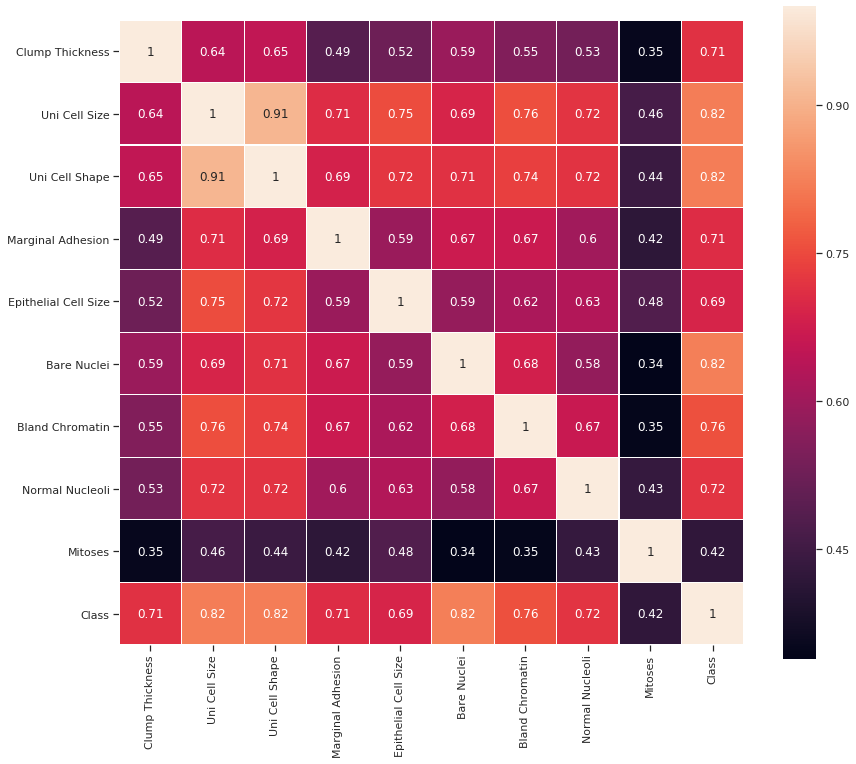

In [44]:
# Displays a heatmap of all columns
sns.set(style='ticks', color_codes=True)
plt.figure(figsize=(14, 12))
sns.heatmap(wbcr_data.astype(float).corr(), linewidths=0.1, square=True, linecolor='white', annot=True)

A heatmap is a great way to show correlation between features. Here we can see a strong correlation between **Uniformity of Cell Size** and **Uniformity of Cell Shape**. Another attribute that might be worth mentioning is **Bland Chromatin** which has a positive correlation of 0.76 with **Uniformity of Cell Size**. What that means is that the size of **Uniformity of Cell Size** increases when **Uniformity of Cell Shape** increases. We could consider removing **Uniformity of Cell Size** or **Uniformity of Cell Shape** as their high correlation may prove to be redundant. We could try building our neural network without removing any columns and see how accurately it performs and then see how the network perfoms after deleting **Uniformity of Cell Shape**.

Benefits of identifying & treating noise in data:

    - enables the algorithm to train faster
    - reduces the complexity of a model and makes it easier to interpret
    - improves the accuracy of a model if the right subset is chosen
    - reduces overfitting

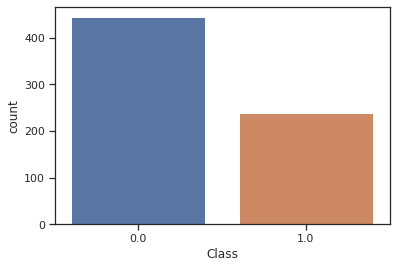

In [45]:
sns.countplot(x='Class', data=wbcr_data)

## 4-fold cross validation
Before building the neural network, we need to split the dataset in 4 folds, 3 for training and 1 for testing. Every fold will be used for testing once and take the scores and average them. This is called k-fold cross validation and you can divide the dataset in k numbers of folds, whatever works best for you (10 folds is a popular amount, but we will be using 4). K-Fold cross validation can be very effective when applied to smaller datasets (100s or 1000s of samples), bigger datasets are computationally more expensive.

The folds are stratified, meaning that the algorithm attempts to balance the number of instances of each class in each fold.

# Artificial Neural Network
We'll build a few models and collect the perfomance of each to see which perfoms best on our dataset. The following configurations will be used:

1. 